# AdvancedBMT Synthetic IIoT Data Generator 

>
> Apr 14, 2025 v0.0.1
>
>- Python 3.12.7
>- Pandas version: 1.4.2
>- Matplotlib version: 3.10.0
>- Scikit-learn version: 1.6.1
>- numpy version: 1.26.4



In [42]:
# ### run this cell for version check
# !python --version
# import pandas
# import matplotlib
# import sklearn
# print("Pandas version:", pandas.__version__)
# print("Matplotlib version:", matplotlib.__version__)
# print("Scikit-learn version:", sklearn.__version__)

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping


🔍 Processing sensor: temperature


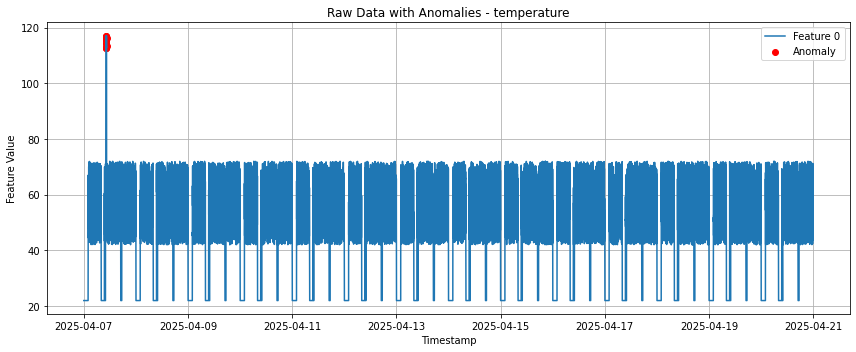

Epoch 1/10


c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/227 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1768

KeyboardInterrupt: 

In [ ]:
# === CONFIG ===
csv_path = "../test_csv/motor_temp_high.csv"
sensors_to_test = ["temperature", "vibration", "rpm", "power"]
window_size = 30
epochs = 10
batch_size = 64
test_size = 0.2
random_state = 42

# === PROCESSING ===
for sensor_name in sensors_to_test:
    print(f"\n🔍 Processing sensor: {sensor_name}")
    df = pd.read_csv(csv_path, parse_dates=["timestamp"])
    sensor_df = df[df["sensor"] == sensor_name].copy()
    sensor_df.sort_values(by="timestamp", inplace=True)
    
    if sensor_df["is_anomaly"].sum() == 0:
        print(f"⚠️ No anomalies in {sensor_name}")
        continue


    # Feature engineering
    le = LabelEncoder()
    sensor_df["state_encoded"] = le.fit_transform(sensor_df["state"])
    scaler = MinMaxScaler()
    features = scaler.fit_transform(sensor_df[["feature_0", "state_encoded"]])
    
    # Create windows
    X, y_true = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y_true.append(int(sensor_df["is_anomaly"].iloc[i:i+window_size].any()))
    
    X, y_true = np.array(X), np.array(y_true)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_true, test_size=test_size, random_state=random_state, stratify=y_true
    )
    
    # LSTM Autoencoder
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, X.shape[2])),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(X.shape[2]))
    ])
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=3)],
        verbose=1
    )
    
    # Predictions
    reconstructions = model.predict(X_test)
    mse = np.mean(np.power(X_test - reconstructions, 2), axis=(1, 2))
    
    # Threshold
    thresholds = np.linspace(np.min(mse), np.max(mse), 100)
    f1_scores = [f1_score(y_test, mse > t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred = (mse > best_threshold).astype(int)
    
    # Results
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Optimal Threshold: {best_threshold:.6f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title(f"Confusion Matrix - {sensor_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Simple visualization of results
    test_timestamps = sensor_df["timestamp"].iloc[-len(X_test):]
    plt.figure(figsize=(12, 5))
    plt.plot(test_timestamps, mse, label="Reconstruction Error")
    plt.scatter(test_timestamps[y_test == 1], mse[y_test == 1],
                color="red", label="True Anomalies")
    plt.axhline(best_threshold, color='black', linestyle='--', 
                label=f'Threshold: {best_threshold:.4f}')
    plt.title(f"Anomaly Detection Results - {sensor_name}")
    plt.xlabel("Timestamp")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()